In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from model.speech_dataloader import thread_loaddata
from model.speech_testdataloader import thread_testloaddata
from model.gpnn import SGPA
from model.learning_rate_schudule import learning_rate_schudule
import pickle
import time

class Acoustic_model(object):
    def __init__(self, layer_sizes, trian_path, valid_path, gpu_id, train_num, valid_num, batch_size):
        self.layer_sizes = layer_sizes
        self.gpu_id = gpu_id
        self.train_loader = thread_loaddata(trian_path, 400)
        self.valid_loader = thread_loaddata(valid_path, 4)
        self.trian_path = trian_path
        self.valid_path = valid_path
        self.train_num = train_num
        self.valid_num = valid_num
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss().cuda()
        self.sgpa = None
        self.optimizer = None
    
    def pretrain(self, EPOCH):
        with torch.cuda.device(self.gpu_id):
            for epoch in range(EPOCH):
                pretrain_layer_sizes = []
                pretrain_layer_sizes.append(self.layer_sizes[0])
                for i in range(epoch+1):
                    pretrain_layer_sizes.append(self.layer_sizes[i+1])
                pretrain_layer_sizes.append(self.layer_sizes[-1])
                if epoch == 0 :
                    self.sgpa = SGPA(pretrain_layer_sizes, 250, 1, 1, gpu_id = self.gpu_id)                   
                    self.optimizer = torch.optim.SGD(self.sgpa.parameters(), lr = 0.001*800, momentum=0.5, weight_decay = 0.001/800)
                else: self.sgpa, self.optimizer = self.reload_network(pretrain_layer_sizes)
                self.sgpa.cuda()
                self.sgpa.train()
                running_time = -time.time()
                train_loss = 0
                train_ll_loss = 0
                train_kl_loss = 0
                train_accuracy = 0
                for iter, (batch_x, batch_y) in enumerate(self.train_loader):
                    if batch_y.size(0) % self.batch_size != 0:
                        total_batch_num = batch_y.size(0)//self.batch_size+1
                    else: total_batch_num = batch_y.size(0)//self.batch_size
                    for batch_num in range(total_batch_num):
                        b_x = Variable(batch_x[batch_num*self.batch_size:(batch_num+1)*self.batch_size,:]).cuda()
                        b_y = Variable(batch_y[batch_num*self.batch_size:(batch_num+1)*self.batch_size]).cuda()
                        train_output = self.sgpa(b_x)
                        train_KL = self.sgpa.kl_cost()
                        loss, nll, kl = self.cal_loss(b_y, train_output, train_KL)
                        self.optimizer.zero_grad()
                        loss.backward()
                        clip_grad_abs(self.sgpa.parameters(), 0.32)
                        self.optimizer.step()
                        train_loss += loss.data[0]
                        train_ll_loss += nll.data[0]
                        train_kl_loss += kl.data[0]
                        train_y_decoded = torch.max(train_output, 1)[1].data.squeeze()
                        train_accuracy += sum(train_y_decoded == b_y.data) / self.train_num                       
                running_time += time.time()
                print('Epoch: ', epoch, '| time: %2fs' % running_time, '| train loss: %.2f' % train_loss, '| train accuracy: %.4f' \
                      % train_accuracy, '| train_ll_loss: %.2f' % train_ll_loss, '| train_kl_loss: %.2f' % train_kl_loss)
                self.sgpa.eval()
                valid_accuracy, valid_loss = self.valid()
                print('Epoch: ', epoch, '| valid loss: %.2f' % valid_loss, '| valid accuracy: %.2f' % valid_accuracy)
                if epoch % 1 == 0 :
                    best_state = self.sgpa.state_dict()
                    self.sgpa.load_state_dict(best_state)
                    model_name = 'model_parameters/gpnn_net_pretrained_' + str(int(epoch+1)) + '.pkl' 
                    torch.save(best_state, model_name)
    
    def train(self, EPOCH):
        self.sgpa = SGPA(self.layer_sizes, 1500, 1, 5, gpu_id = self.gpu_id)
#         self.optimizer = torch.optim.SGD(self.sgpa.parameters(), lr = 0.002*800, momentum=0.5, weight_decay = 0.001/800)
        self.optimizer = torch.optim.Adam(self.sgpa.parameters(), lr = 0.002, weight_decay = 0.001/800, amsgrad=True)
#         dict_trained = torch.load('model_parameters/gpnn_net_pretrained_4.pkl', map_location=lambda storage, loc: storage.cuda(gpu_id))
#         dict_new = self.sgpa.state_dict()
#         trained_list = list(dict_trained.keys())
#         new_list = list(dict_new.keys())
#         for i in range(3+2*(len(self.layer_sizes)-4)):
#             dict_new[ new_list[i] ] = dict_trained[ trained_list[i] ]
#         self.sgpa.load_state_dict(dict_new)
        local_monitor_value = 0
        best_valid_accuracy = 0
        best_state = {}
        max_iter = 5
        count = 0
        with torch.cuda.device(self.gpu_id):
            self.sgpa.cuda()
            for epoch in range(EPOCH):
                self.sgpa.train()
                running_time = -time.time()
                train_loss = 0
                train_ll_loss = 0
                train_kl_loss = 0
                train_accuracy = 0
                for iter, (batch_x, batch_y) in enumerate(self.train_loader):
                    if batch_y.size(0) % self.batch_size != 0:
                        total_batch_num = batch_y.size(0)//self.batch_size+1
                    else: total_batch_num = batch_y.size(0)//self.batch_size
                    for batch_num in range(total_batch_num):
                        b_x = Variable(batch_x[batch_num*self.batch_size:(batch_num+1)*self.batch_size,:]).cuda()
                        b_y = Variable(batch_y[batch_num*self.batch_size:(batch_num+1)*self.batch_size]).cuda()
                        train_output = self.sgpa(b_x)
                        train_KL = self.sgpa.kl_cost()
                        loss, nll, kl = self.cal_loss(b_y, train_output, train_KL)
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.clip_grad_abs(0.32)
                        self.optimizer.step()
                        train_loss += loss.item()#data[0]
                        train_ll_loss += nll.item()#data[0]
                        train_kl_loss += kl.item()#data[0]
                        train_y_decoded = torch.max(train_output, 1)[1]#data.squeeze()
#                         train_accuracy += sum(train_y_decoded == b_y) / self.train_num
                        train_accuracy += torch.sum(torch.eq(train_y_decoded,b_y)).item() / self.train_num
                learning_rate = self.optimizer.param_groups[0]['lr']
                running_time += time.time()
                print('Epoch: ', epoch, '| time: %2fs' % running_time, '| learning rate: %e' % learning_rate, '| train loss: %.2f' \
                      % train_loss, '| train accuracy: %.4f' % train_accuracy, '| train_ll_loss: %.2f' % train_ll_loss, \
                      '| train_kl_loss: %.2f' % train_kl_loss)                
                self.sgpa.eval()
                valid_accuracy, valid_loss = self.valid()
                if best_valid_accuracy < valid_accuracy:
                    best_valid_loss = valid_loss
                    best_valid_accuracy = valid_accuracy
                    local_monitor_value = valid_accuracy
                    count = 0
                    self.sgpa.cpu()
                    best_state = self.sgpa.state_dict()
                    self.sgpa.load_state_dict(best_state)
                    torch.save(best_state, 'model_parameters/best_net_sgd.pkl') 
                    self.sgpa.cuda()
                else: 
                    count += 1
                self.optimizer, self.sgpa = learning_rate_schudule(self.sgpa, self.optimizer, valid_accuracy, local_monitor_value, \
                                                                   best_state, startdiff = 0.001, mode = 'max', factor = 0.5, patience = 2)
                print('Epoch: ', epoch, '| best valid loss: %.4f' % best_valid_loss, '| best valid accuracy: %.4f' % best_valid_accuracy, \
                      '| valid loss: %.4f' % valid_loss, '| valid accuracy: %.4f' % valid_accuracy)
                if count > max_iter:
                    print('No improvement for %d epochs' % max_iter)
                    break     
    
    def valid(self):
        valid_loss = 0
        valid_accuracy = 0
        for step, (batch_valid_x, batch_valid_y) in enumerate(self.valid_loader):
            b_valid_x = Variable(batch_valid_x).cuda()
            b_valid_y = Variable(batch_valid_y).cuda()
            valid_output = self.sgpa(b_valid_x)
            valid_KL = self.sgpa.kl_cost()
            loss, nll, kl = self.cal_loss(b_valid_y, valid_output, valid_KL)
            valid_loss += nll.item()#data[0]
            valid_y_decoded = torch.max(valid_output, 1)[1]
#             valid_accuracy += torch.sum(torch.eq(valid_y_decoded,b_valid_y).item() / self.valid_num
            valid_accuracy += torch.sum(torch.eq(valid_y_decoded,b_valid_y)).item() / self.valid_num
        return valid_accuracy, valid_loss
    
    def test(self):
        with open('../prior.pickle','rb') as prior_file:
            prior = pickle.load(prior_file)        
        self.sgpa = SGPA(self.layer_sizes, 1500, 1, 5, gpu_id = self.gpu_id)
        self.sgpa.load_state_dict(torch.load('model_parameters/best_net_sgd.pkl'))
        softmax = nn.Softmax(dim=1)
        for scp_name in ['ind_feb89', 'ind_feb91', 'ind_oct89', 'ind_sep92']:
            test_path = '../../lib/flists/'+scp_name+'.scp'
            test_loader = thread_testloaddata(test_path, 1)
            test_path_list = []
            with open(test_path, 'r') as f3:
                for line in f3.readlines():
                    line = line.strip()
                    test_path_list.append(line)              
            write_path = 'ark_data/'+scp_name+'.output'
            f = open(write_path, 'w')
            with torch.cuda.device(gpu_id):
                self.sgpa = self.sgpa.cuda()
                self.sgpa.eval()
                for iter, (batch_x, batch_y) in enumerate(test_loader):
                    file_name = test_path_list[iter].split('/')[-1]
                    X_test = torch.FloatTensor(batch_x)
                    test_x = Variable(X_test).cuda()
                    test_output = self.sgpa(test_x)
                    test_output = softmax(test_output)
                    output = np.array(test_output.detach().cpu().numpy()) + (1e-40)*np.ones(689)
                    output = np.log(output)-np.log(prior)
                    f.write(file_name.split('.')[0] + '  [' + '\n')
                    R = output.shape[0]
                    for i in range(R-1):
                        f.write('  ')
                        f.write(' '.join(str(v) for v in output[i,:].tolist()))
                        f.write(' \n')
                    f.write('  ')
                    f.write(' '.join(str(v) for v in output[R-1,:].tolist())+' ]')
                    f.write('\n')
            f3.close()
            f.close()

    
    def cal_loss(self, y, output, KL):
        nll = self.loss_func(output,y)
        kl = KL/output.size(0)
        loss = nll + kl
        return loss, nll, kl
    
    def reload_network(self, layer_sizes):
        Num_layer = len(layer_sizes)
        self.sgpa = SGPA(layer_sizes, 250, 1, 1, gpu_id = self.gpu_id)
        model_name = 'model_parameters/gpnn_net_pretrained_' + str(int(Num_layer-3)) + '.pkl' 
        dict_trained = torch.load( model_name )
        dict_new = self.sgpa.state_dict()
        trained_list = list(dict_trained.keys())
        new_list = list(dict_new.keys())
        for i in range(3+2*(Num_layer-4)):
            dict_new[ new_list[i] ] = dict_trained[ trained_list[i] ]
        self.sgpa.load_state_dict(dict_new)
        for temp, p in enumerate(self.sgpa.parameters()):
            if temp < 3 + 2*(Num_layer-4):
                p.requires_grad = False
        self.optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, self.sgpa.parameters()), lr = 0.001*800, \
                                         momentum=0.5, weight_decay = 0.001/800)
        return self.sgpa, self.optimizer
    
    def clip_grad_abs(self, max_norm):
        parameters = list(filter(lambda p: p.grad is not None, self.sgpa.parameters()))
        max_norm = float(max_norm)
        for p in parameters:
            p.grad.data[p.grad.data>max_norm] = max_norm
            p.grad.data[p.grad.data<-max_norm] = -max_norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpu_id = 3
batch_size = 800
train_num = 1255588
valid_num = 106849
layer_sizes = [351, 3000, 3000, 3000, 3000, 3000, 689]
trian_path = '/scratch/bdda/skhu/RM/lib/flists/train.scp'
valid_path = '/scratch/bdda/skhu/RM/lib/flists/cv.scp'
model = Acoustic_model(layer_sizes, trian_path, valid_path, gpu_id, train_num, valid_num, batch_size)
# model.pretrain(4)
model.train(100)
# model.test()

Epoch:  0 | time: 434.808728s | learning rate: 2.000000e-03 | train loss: 4817.13 | train accuracy: 0.3804 | train_ll_loss: 4363.11 | train_kl_loss: 454.02
Epoch:  0 | best valid loss: 198.4069 | best valid accuracy: 0.3864 | valid loss: 198.4069 | valid accuracy: 0.3864
Epoch:  1 | time: 436.011472s | learning rate: 2.000000e-03 | train loss: 3586.50 | train accuracy: 0.4495 | train_ll_loss: 3585.82 | train_kl_loss: 0.68
Epoch:  1 | best valid loss: 198.4069 | best valid accuracy: 0.3864 | valid loss: 208.6207 | valid accuracy: 0.3758
Epoch:  2 | time: 437.190299s | learning rate: 2.000000e-03 | train loss: 3341.74 | train accuracy: 0.4758 | train_ll_loss: 3340.90 | train_kl_loss: 0.84
Epoch:  2 | best valid loss: 180.7530 | best valid accuracy: 0.4265 | valid loss: 180.7530 | valid accuracy: 0.4265
Epoch:  3 | time: 436.594376s | learning rate: 2.000000e-03 | train loss: 3124.84 | train accuracy: 0.4995 | train_ll_loss: 3123.92 | train_kl_loss: 0.91
Epoch:  3 | best valid loss: 174.4

In [6]:
gpu_id = 3
batch_size = 800
train_num = 1255588
valid_num = 106849
layer_sizes = [351, 3000, 3000, 3000, 3000, 3000, 689]
trian_path = '/scratch/bdda/skhu/RM/lib/flists/train.scp'
valid_path = '/scratch/bdda/skhu/RM/lib/flists/cv.scp'
model = Acoustic_model(layer_sizes, trian_path, valid_path, gpu_id, train_num, valid_num, batch_size)
# model.pretrain(4)
# model.train(100)
model.test()

In [ ]:
import torch
torch.zeros(2,3)

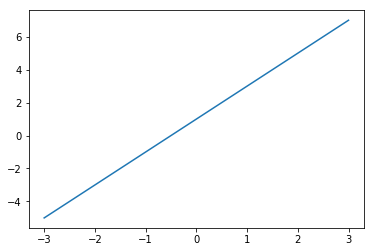

In [6]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-3, 3, 50)
y1 = 2*x + 1
y2 = x**2
plt.figure()
plt.plot(x, y1)
plt.savefig('1.png')
plt.show()